In [4]:
%matplotlib inline
import sys
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")

import matplotlib.pyplot as plt
import numpy as np

from icglm.models.glm import GLM
from icglm.kernels.rect import KernelRect
from icglm.processes import OUProcess

%load_ext autoreload
%autoreload 2

### Define stimulus process, GLM and sample a spike train

In [5]:
t = np.arange(0, 2000, 1)
mu, sd = 30, 25
ou = OUProcess(mu=mu, sd=sd, tau=3)
stim = ou.sample(t, seed=0, shape=(1,))
stim = np.concatenate([stim] * 50, 1)

u0 = 16
kappa = KernelRect.exponential(tf=240, dt=8, tau=40, A=1e-2)
eta = KernelRect.exponential(tf=450, dt=25, tau=75, A=7)
glm_true = GLM(u0=u0, kappa=kappa, eta=eta)

np.random.seed(0)
v, r, mask_spk_true = glm_true.sample(t, stim)

### Decode stimulus

Starting gradient ascent... 

 Iteration 9 of 30 | Elapsed time: 2.33 seconds | log_prior=-73.03 | log_posterior=-2959.61
 
 Iteration 9 of 30 | Converged | Elapsed time: 0.0389 minutes | Log posterior is monotonic 



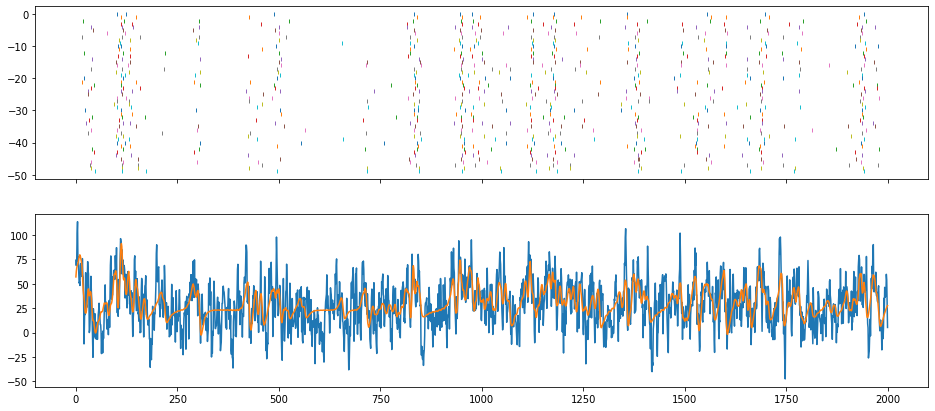

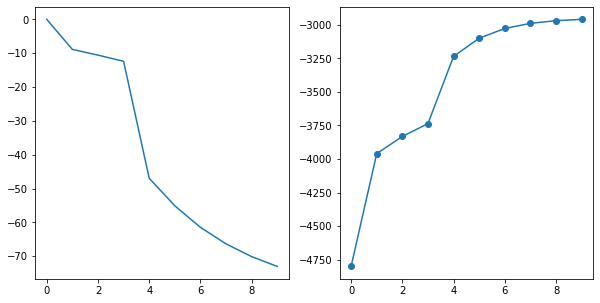

In [6]:
newton_kwargs = dict(max_iterations=30, stop_cond=5e-6, learning_rate=5e-1, initial_learning_rate=5e-2, warm_up_iterations=3)

# ou.set_dt(1)
stim0 = np.zeros(len(t)) + mu
stim_dec, optimizer = glm_true.decode(t, mask_spk_true, stim0=stim0, prior=ou, newton_kwargs=newton_kwargs, verbose=True)

fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), nrows=2, sharex=True)
for sw in range(mask_spk_true.shape[1]):
    _mask = mask_spk_true[:, sw]
    ax1.plot(t[_mask], np.zeros(np.sum(_mask)) - sw, '|', ms=4)
ax2.plot(t, np.mean(stim, 1))
ax2.plot(t, stim_dec)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
ax1.plot(optimizer.log_prior_iterations)
ax2.plot(optimizer.log_posterior_iterations, '-o')